# Deep Learning: Assignment 6B

<ol>
<li>Change the dataset for feedforward network
<li>Change the network accordingly.
<li>Apply the same optimizers given above for the simple FeedForward-Neural Network<br>consisting and experiment using various optimizers to solve multi-class classification problem on dummy data.
</ol>

### Import necessary libraries

In [1]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss

In [2]:
sns.set()

### Generate Data

In [3]:
data, labels = make_blobs(n_samples = 1000, n_features = 2, centers = 4, random_state = 0)
print(data.shape, labels. shape)

(1000, 2) (1000,)


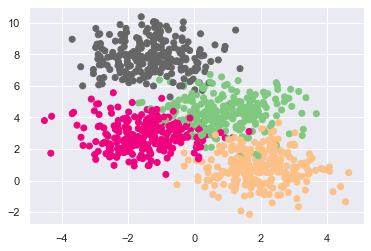

In [4]:
#plt.figure(figsize = (6, 4), dpi = 125)
plt.scatter(data[:, 0], data[:, 1], c = labels, cmap = 'Accent')
#plt.plot()

### Multiclass Classification

In [5]:
X_train, X_val, Y_train, Y_val = train_test_split(data, labels, stratify = labels, random_state = 0)
print(X_train.shape, Y_train.shape, X_val.shape)

(750, 2) (750,) (250, 2)


In [6]:
enc = OneHotEncoder()
Y_OH_train = enc.fit_transform(np.expand_dims(Y_train, 1)).toarray()
Y_OH_val = enc.fit_transform(np.expand_dims(Y_val, 1)).toarray()

### Feedforward Network

In [7]:
W1 = np.random.randn(2,2)
W2 = np.random.randn(2,4)

In [8]:
class network:
    def __init__(self, W1, W2):

        self.params = {}
        self.params["W1"] = W1.copy()
        self.params["W2"] = W2.copy()
        self.params["B1"] = np.zeros((1, 2))
        self.params["B2"] = np.zeros((1, 4))
        self.gradients = {}
        self.num_layers = 2
        self.update_params = {}
        self.prev_update_params = {}

        for i in range(1, self.num_layers + 1):
            self.update_params["v_w"+str(i)] = 0
            self.update_params["v_b"+str(i)] = 0
            self.update_params["m_w"+str(i)] = 0
            self.update_params["m_b"+str(i)] = 0
            self.prev_update_params["v_w"+str(i)] = 0
            self.prev_update_params["v_b"+str(i)] = 0
    
    def sigmoid(self, X):
        return 1.0 / (1.0 + np.exp(-X))
    
    def softmax(self, X):
        exps = np.exp(X)
        return exps / np.sum(exps, axis = 1).reshape(-1, 1)
    
    def forwardPass(self, X, params = None):
        if params is None: params = self.params

        self.A1 = np.matmul(X, params["W1"]) + params["B1"]            # (N, 2) * (2, 2) -> (N, 2)
        self.H1 = self.sigmoid(self.A1)                                          # (N, 2)
        self.A2 = np.matmul(self.H1, params["W2"]) + params["B2"]      # (N, 2) * (2, 4) -> (N, 4)
        self.H2 = self.softmax(self.A2)                                          # (N, 4)
        return self.H2                                                           # (N, 4)
    
    def backpropagation(self, X, Y, params = None):
        if params is None: params = self.params

        m = X.shape[0]
        self.forwardPass(X, params)

        self.gradients["dA2"] = self.H2 - Y                                                     # (N, 4)
        self.gradients["dW2"] = np.matmul(self.H1.T, self.gradients["dA2"])                     # (2, N) * (N, 4) -> (2, 4)
        self.gradients["dB2"] = np.sum(self.gradients["dA2"], axis = 0).reshape(1, -1)          # (N, 4) -> (1, 4)
        self.gradients["dH1"] = np.matmul(self.gradients["dA2"], params["W2"].T)                # (N, 4) * (4, 2) -> (N, 2)
        self.gradients["dA1"] = np.multiply(self.gradients["dH1"], (self.H1 * (1 - self.H1)))   # (N, 2) .* (N, 2) -> (N, 2)
        self.gradients["dW1"] = np.matmul(X.T, self.gradients["dA1"])                           # (2, N) * (N, 4) -> (2, 4)
        self.gradients["dB1"] = np.sum(self.gradients["dA1"], axis = 0).reshape(1, -1)          # (N, 2) -> (1, 2)
    
    def fit(self, X, Y, algo = 'GD', epochs = 1, eta = 1.0, display_loss = True, 
            minibatch_size = 128, gamma = 0.9, eps = 1e-8, beta = 0.9, beta1 = 0.9,
            beta2 = 0.9):
        if display_loss:
            loss = {}
        
        m = X.shape[0]
        for e in tqdm(range(epochs), total = epochs, unit = "epoch"):
            if algo == 'GD':
                self.backpropagation(X, Y)
                for i in range(1, self.num_layers + 1):
                    self.params["W"+str(i)] -= (eta * (self.gradients["dW"+str(i)] / m))
                    self.params["B"+str(i)] -= (eta * (self.gradients["dB"+str(i)] / m))
            
            if algo == 'MiniBatch':
                for k in range(0, m, minibatch_size):
                    self.backpropagation(X[k:k + minibatch_size], Y[k:k + minibatch_size])
                    for i in range(1, self.num_layers + 1):
                        self.params["W"+str(i)] -= (eta * (self.gradients["dW"+str(i)] / minibatch_size))
                        self.params["B"+str(i)] -= (eta * (self.gradients["dB"+str(i)] / minibatch_size))
            
            if algo == 'Momentum':
                self.backpropagation(X, Y)
                for i in range(1, self.num_layers + 1):
                    self.update_params["v_w"+str(i)] = gamma * self.update_params["v_w"+str(i)] + eta * (self.gradients["dW"+str(i)] / m)
                    self.update_params["v_b"+str(i)] = gamma * self.update_params["v_b"+str(i)] + eta * (self.gradients["dB"+str(i)] / m)
                    self.params["W"+str(i)] -= self.update_params["v_w"+str(i)]
                    self.params["B"+str(i)] -= self.update_params["v_b"+str(i)]
            
            if algo == "NAG":
                temp_params = {}
                for i in range(1, self.num_layers + 1):
                    self.update_params["v_w"+str(i)] = gamma * self.prev_update_params["v_w"+str(i)]
                    self.update_params["v_b"+str(i)] = gamma * self.prev_update_params["v_b"+str(i)]
                    
                    temp_params["W"+str(i)] = self.params["W"+str(i)] - self.update_params["v_w"+str(i)]
                    temp_params["B"+str(i)] = self.params["B"+str(i)] - self.update_params["v_b"+str(i)]
                self.backpropagation(X, Y, temp_params)
                for i in range(1, self.num_layers + 1):
                    self.update_params["v_w"+str(i)] = gamma * self.update_params["v_w"+str(i)] + eta * (self.gradients["dW"+str(i)] / m)
                    self.update_params["v_b"+str(i)] = gamma * self.update_params["v_b"+str(i)] + eta * (self.gradients["dB"+str(i)] / m)
                    self.params["W"+str(i)] -= eta * (self.update_params["v_w"+str(i)])
                    self.params["B"+str(i)] -= eta * (self.update_params["v_b"+str(i)])
                self.prev_update_params = self.update_params
            
            if algo == "AdaGrad":
                self.backpropagation(X, Y)
                for i in range(1, self.num_layers + 1):
                    self.update_params["v_w"+str(i)] += ((self.gradients["dW"+str(i)] / m) ** 2)
                    self.update_params["v_b"+str(i)] += ((self.gradients["dB"+str(i)] / m) ** 2)
                    self.params["W"+str(i)] -= (eta / (np.sqrt(self.update_params["v_w"+str(i)]) + eps)) * (self.gradients["dW"+str(i)] / m)
                    self.params["B"+str(i)] -= (eta / (np.sqrt(self.update_params["v_b"+str(i)]) + eps)) * (self.gradients["dB"+str(i)] / m)
            
            if algo == "RMSProp":
                self.backpropagation(X, Y)
                for i in range(1, self.num_layers + 1):
                    self.update_params["v_w"+str(i)] = beta * (self.update_params["v_w"+str(i)]) + (1 - beta) * ((self.gradients["dW"+str(i)] / m) ** 2)
                    self.update_params["v_b"+str(i)] = beta * (self.update_params["v_b"+str(i)]) + (1 - beta) * ((self.gradients["dB"+str(i)] / m) ** 2)
                    self.params["W"+str(i)] -= (eta / (np.sqrt(self.update_params["v_w"+str(i)]) + eps)) * (self.gradients["dW"+str(i)] / m)
                    self.params["B"+str(i)] -= (eta / (np.sqrt(self.update_params["v_b"+str(i)]) + eps)) * (self.gradients["dB"+str(i)] / m)
            
            if algo == "Adam":
                self.backpropagation(X, Y)
                num_updates = 0
                for i in range(1, self.num_layers + 1):
                    num_updates += 1
                    self.update_params["m_w"+str(i)] = beta1 * (self.update_params["m_w"+str(i)]) + (1 - beta1) * (self.gradients["dW"+str(i)] / m)
                    self.update_params["v_w"+str(i)] = beta2 * (self.update_params["v_w"+str(i)]) + (1 - beta2) * ((self.gradients["dW"+str(i)] / m) ** 2)
                    m_w_c = self.update_params["m_w"+str(i)] / (1 - np.power(beta1, num_updates))
                    v_w_c = self.update_params["v_w"+str(i)] / (1 - np.power(beta2, num_updates))
                    self.params["W"+str(i)] -= (eta / (np.sqrt(v_w_c + eps))) * m_w_c

                    self.update_params["m_b"+str(i)] = beta1 * (self.update_params["m_b"+str(i)]) + (1 - beta1) * (self.gradients["dB"+str(i)] / m)
                    self.update_params["v_b"+str(i)] = beta2 * (self.update_params["v_b"+str(i)]) + (1 - beta2) * ((self.gradients["dB"+str(i)] / m) ** 2)
                    m_w_c = self.update_params["m_b"+str(i)] / (1 - np.power(beta1, num_updates))
                    v_w_c = self.update_params["v_b"+str(i)] / (1 - np.power(beta2, num_updates))
                    self.params["B"+str(i)] -= (eta / (np.sqrt(v_w_c + eps))) * m_w_c

            if display_loss:
                Y_pred = self.predict(X)
                loss[e] = log_loss(Y, Y_pred)
        
        if display_loss:
            plt.plot(list(loss.values()), '-o', markersize = 3)
            plt.xlabel('Epochs')
            plt.ylabel('Log Loss')
            plt.show()
    
    def predict(self, X):
        Y_pred = self.forwardPass(X)
        return np.array(Y_pred).squeeze()

In [9]:
def accuracy_summary(display_graph = False):
    Y_pred_train = model.predict(X_train)
    Y_pred_val = model.predict(X_val)

    Y_pred_train = np.argmax(Y_pred_train, 1)
    Y_pred_val = np.argmax(Y_pred_val, 1)

    accuracy_train = accuracy_score(Y_train, Y_pred_train)
    accuracy_val = accuracy_score(Y_val, Y_pred_val)

    print("Training accuracy", round(accuracy_train, 4))
    print("Validation accuracy", round(accuracy_val, 4))

    if display_graph:
        plt.scatter(X_train[:,0], X_train[:,1], c=Y_pred_train, cmap='Set2', s=15*(np.abs(np.sign(Y_pred_train-Y_train))+.1))
        plt.show()

100%|██████████| 100/100 [00:00<00:00, 265.27epoch/s]


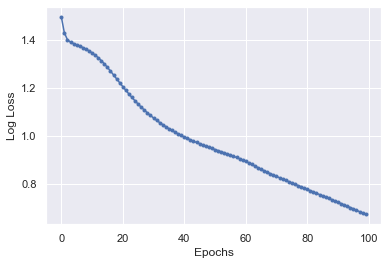

Training accuracy 0.7933
Validation accuracy 0.776
Wall time: 822 ms


In [10]:
%%time
model = network(W1, W2)
model.fit(X_train, Y_OH_train, algo = "GD", epochs = 100, eta = 1)
accuracy_summary()

100%|██████████| 100/100 [00:00<00:00, 213.23epoch/s]


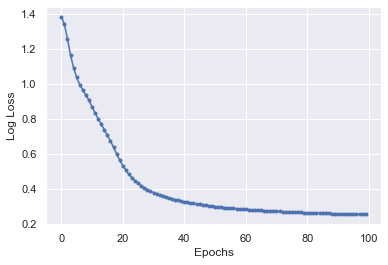

Training accuracy 0.904
Validation accuracy 0.912
Wall time: 949 ms


In [11]:
%%time
model = network(W1, W2)
model.fit(X_train, Y_OH_train, algo = "MiniBatch", epochs = 100, eta = 1, minibatch_size = 128)
accuracy_summary()

100%|██████████| 100/100 [00:01<00:00, 54.22epoch/s]


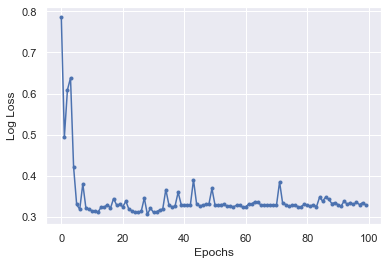

Training accuracy 0.8707
Validation accuracy 0.872
Wall time: 2.33 s


In [12]:
%%time
model = network(W1, W2)
model.fit(X_train, Y_OH_train, algo = "MiniBatch", epochs = 100, eta = 1, minibatch_size = 8)
accuracy_summary()

100%|██████████| 100/100 [00:00<00:00, 324.29epoch/s]


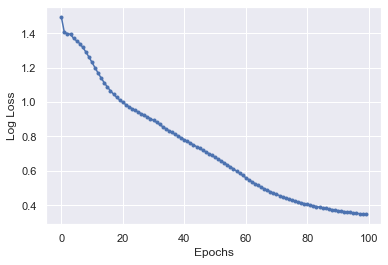

Training accuracy 0.892
Validation accuracy 0.908
Wall time: 731 ms


In [13]:
%%time
model = network(W1, W2)
model.fit(X_train, Y_OH_train, algo = "Momentum", epochs = 100, eta = 1, gamma = 0.5)
accuracy_summary()

100%|██████████| 100/100 [00:00<00:00, 315.31epoch/s]


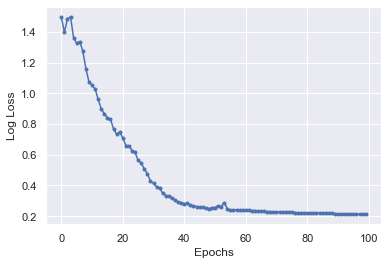

Training accuracy 0.9187
Validation accuracy 0.94
Wall time: 797 ms


In [14]:
%%time
model = network(W1, W2)
model.fit(X_train, Y_OH_train, algo = "Momentum", epochs = 100, eta = 1, gamma = 0.9)
accuracy_summary()

100%|██████████| 100/100 [00:00<00:00, 332.98epoch/s]


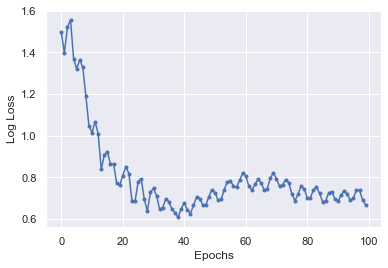

Training accuracy 0.7373
Validation accuracy 0.728
Wall time: 734 ms


In [15]:
%%time
model = network(W1, W2)
model.fit(X_train, Y_OH_train, algo = "Momentum", epochs = 100, eta = 1, gamma = 0.99)
accuracy_summary()

100%|██████████| 100/100 [00:00<00:00, 319.39epoch/s]


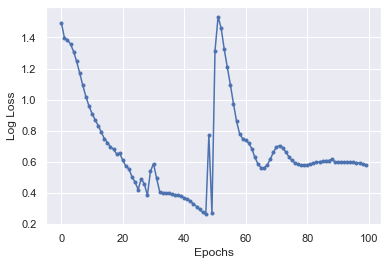

Training accuracy 0.7333
Validation accuracy 0.74
Wall time: 760 ms


In [16]:
%%time
model = network(W1, W2)
model.fit(X_train, Y_OH_train, algo = "NAG", epochs = 100, eta = 1, gamma = 0.99)
accuracy_summary()

100%|██████████| 100/100 [00:00<00:00, 325.26epoch/s]


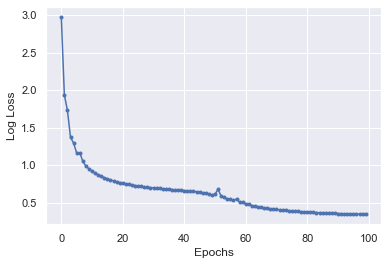

Training accuracy 0.8853
Validation accuracy 0.896
Wall time: 881 ms


In [17]:
%%time
model = network(W1, W2)
model.fit(X_train, Y_OH_train, epochs=100, eta=1, algo="AdaGrad", display_loss=True)
accuracy_summary()

100%|██████████| 100/100 [00:00<00:00, 323.66epoch/s]


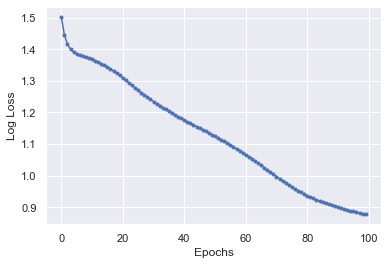

Training accuracy 0.656
Validation accuracy 0.684
Wall time: 862 ms


In [18]:
%%time
model = network(W1, W2)
model.fit(X_train, Y_OH_train, epochs=100, eta=.1, algo="AdaGrad", display_loss=True)
accuracy_summary()

100%|██████████| 100/100 [00:00<00:00, 306.47epoch/s]


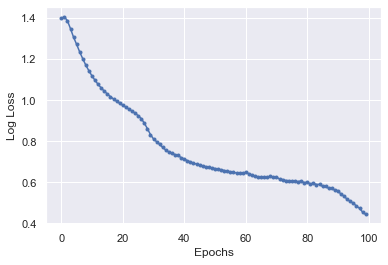

Training accuracy 0.86
Validation accuracy 0.848
Wall time: 750 ms


In [19]:
%%time
model = network(W1, W2)
model.fit(X_train, Y_OH_train, epochs=100, eta=.1, algo="RMSProp", beta=0.9, display_loss=True)
accuracy_summary()

100%|██████████| 100/100 [00:00<00:00, 323.45epoch/s]


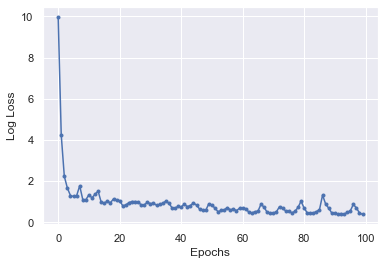

Training accuracy 0.8813
Validation accuracy 0.872
Wall time: 773 ms


In [20]:
%%time
model = network(W1, W2)
model.fit(X_train, Y_OH_train, epochs=100, eta=.9, algo="RMSProp", beta=0.9, display_loss=True)
accuracy_summary()

100%|██████████| 100/100 [00:00<00:00, 312.36epoch/s]


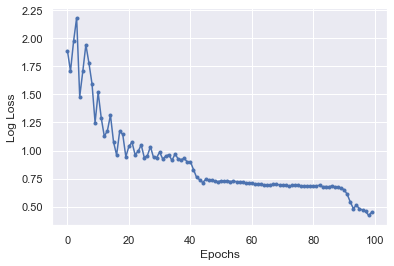

Training accuracy 0.8467
Validation accuracy 0.872
Wall time: 792 ms


In [21]:
%%time
model = network(W1, W2)
model.fit(X_train, Y_OH_train, epochs=100, eta=.9, algo="Adam", beta=0.9, display_loss=True)
accuracy_summary()

100%|██████████| 100/100 [00:00<00:00, 309.43epoch/s]


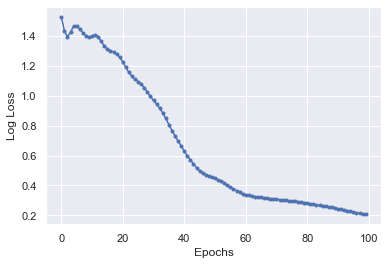

Training accuracy 0.9253
Validation accuracy 0.94


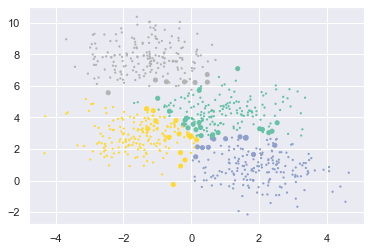

Wall time: 1.24 s


In [22]:
%%time
model = network(W1, W2)
model.fit(X_train, Y_OH_train, epochs=100, eta=.1, algo="Adam", beta=0.9, display_loss=True)
accuracy_summary(display_graph = True)

**Good Configuration for Each Algorithm**

100%|██████████| 10000/10000 [00:31<00:00, 313.67epoch/s]


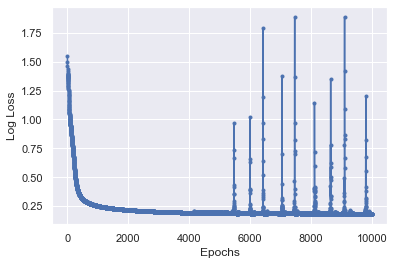

Training accuracy 0.9267
Validation accuracy 0.94
Wall time: 32.5 s


In [23]:
%%time
model = network(W1, W2)
model.fit(X_train, Y_OH_train, epochs=10000, eta=0.5, algo="GD", display_loss=True)
accuracy_summary()

100%|██████████| 1000/1000 [00:03<00:00, 307.97epoch/s]


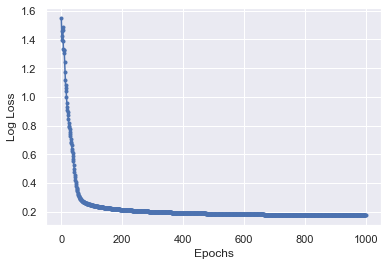

Training accuracy 0.9267
Validation accuracy 0.944
Wall time: 3.68 s


In [24]:
%%time
model = network(W1, W2)
model.fit(X_train, Y_OH_train, epochs=1000, eta=0.5, algo="Momentum", gamma=0.9, display_loss=True)
accuracy_summary()

100%|██████████| 1000/1000 [00:03<00:00, 303.95epoch/s]


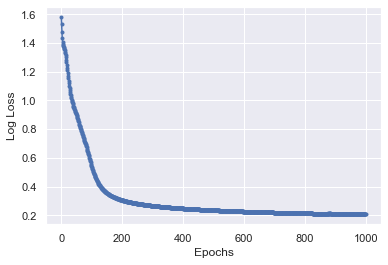

Training accuracy 0.9147
Validation accuracy 0.94
Wall time: 3.77 s


In [25]:
%%time
model = network(W1, W2)
model.fit(X_train, Y_OH_train, epochs=1000, eta=0.5, algo="NAG", gamma=0.9, display_loss=True)
accuracy_summary()

100%|██████████| 500/500 [00:01<00:00, 317.82epoch/s]


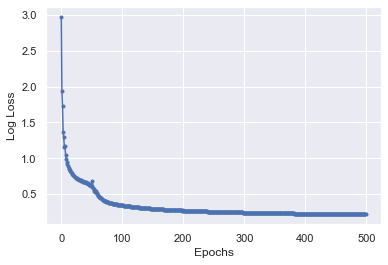

Training accuracy 0.9107
Validation accuracy 0.94
Wall time: 2.06 s


In [26]:
%%time
model = network(W1, W2)
model.fit(X_train, Y_OH_train, epochs=500, eta=1, algo="AdaGrad", display_loss=True)
accuracy_summary()

100%|██████████| 2000/2000 [00:07<00:00, 268.36epoch/s]


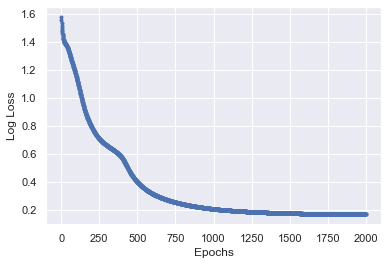

Training accuracy 0.9307
Validation accuracy 0.94
Wall time: 7.92 s


In [27]:
%%time
model = network(W1, W2)
model.fit(X_train, Y_OH_train, epochs=2000, eta=.01, algo="RMSProp", beta=0.9, display_loss=True)
accuracy_summary()

100%|██████████| 200/200 [00:00<00:00, 290.40epoch/s]


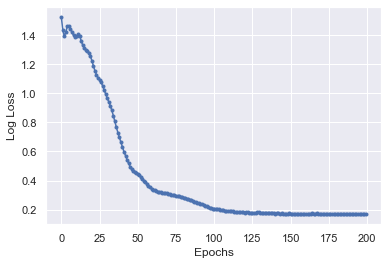

Training accuracy 0.9267
Validation accuracy 0.944
Wall time: 1.15 s


In [28]:
%%time
model = network(W1, W2)
model.fit(X_train, Y_OH_train, epochs=200, eta=.1, algo="Adam", beta=0.9, display_loss=True)
accuracy_summary()